# Pictionary Model - Can you beat the machine?


Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas nunc ipsum, condimentum non blandit ac, feugiat at dolor. Sed pulvinar elit ac sagittis faucibus. Curabitur in felis dui. Proin condimentum sagittis enim, et lacinia ante mollis eu. Praesent suscipit tortor non augue auctor egestas. Sed in sapien sed justo ullamcorper ornare sodales ac diam. 

Ut non mollis neque. Pellentesque sapien enim, dignissim at vestibulum sed, sodales eget lacus. Nullam bibendum at tellus a eleifend. Duis vitae dictum est. Nunc non dui malesuada, tempor nunc in, condimentum lacus. Vivamus ornare enim felis, quis porttitor lacus auctor sed. Aliquam tempor, sapien vitae placerat faucibus, nunc felis sollicitudin libero, non condimentum augue ipsum in diam. Aenean feugiat arcu eu massa lobortis, non imperdiet nisi lacinia. Aliquam odio elit, congue a efficitur quis, tristique ac augue.



In [26]:
from google.cloud import storage
import os
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import random
# PyTorch
import torch
import torchvision.models as models
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
# Sagemaker utils
from sagemaker.pytorch import PyTorchModel
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
import sagemaker
import pickle
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import pickle
from utils.helper_functions import *
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel
from sklearn.metrics import accuracy_score

## Data Download
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas nunc ipsum, condimentum non blandit ac, feugiat at dolor. Sed pulvinar elit ac sagittis faucibus. Curabitur in felis dui. Proin condimentum sagittis enim, et lacinia ante mollis eu. Praesent suscipit tortor non augue auctor egestas. Sed in sapien sed justo ullamcorper ornare sodales ac diam. 

In [2]:
folder = 'data'
transformedFolder = 'data/transformed'

# Create folders
if not os.path.isdir(folder):
    os.makedirs(folder)
if not os.path.isdir(transformedFolder):
    os.makedirs(transformedFolder)

# Datasets to be downloaded.
dataset = ['bicycle.npy', 'cake.npy', 'chair.npy', 'bird.npy', 'The Mona Lisa.npy'
          ,'cruise ship.npy', 'airplane.npy', 'boomerang.npy', 'sock.npy', 'windmill.npy', 
           'radio.npy', 'lollipop.npy' , 'tooth.npy', 'church.npy', 'angel.npy',
           'rabbit.npy', 'pickup truck.npy', 'cell phone.npy', 'teddy-bear.npy', 'house.npy',
           'donut.npy', 'finger.npy', 'pants.npy', 'hat.npy', 'castle.npy', 'map.npy', 'car.npy',
           'cookie.npy', 'jail.npy', 'mug.npy'
          ]

print(f'Creating the model on {len(dataset)} targets.')

Creating the model on 30 targets.


In [3]:
# Create client to download from Google Storage
prefix = 'full/numpy_bitmap'
storage_client = storage.Client.from_service_account_json('keys/googleKey.json')
bucket = storage_client.bucket(bucket_name='quickdraw_dataset')

In [4]:
# Download data from Quick Draw Dataset. Only download delta dataset.
for blob in bucket.list_blobs(prefix=prefix):
    blobName = blob.name.split('/')[-1]
    if blobName in dataset and not os.path.isfile(f"{folder}/{blobName}"):
        targetName = f"{folder}/{blobName}"
        print(f'Downloading: "{blob.name}" to {targetName}.')
        blob.download_to_filename(targetName)
print('Data Downloaded.')

Data Downloaded.


## Data Visualisation
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas nunc ipsum, condimentum non blandit ac, feugiat at dolor. Sed pulvinar elit ac sagittis faucibus. Curabitur in felis dui. Proin condimentum sagittis enim, et lacinia ante mollis eu. Praesent suscipit tortor non augue auctor egestas. Sed in sapien sed justo ullamcorper ornare sodales ac diam. 

In [5]:
dataLimit = 75000
loadedData = {name.split('.')[0]: np.load(f'data/{name}')[:dataLimit] for name in dataset}

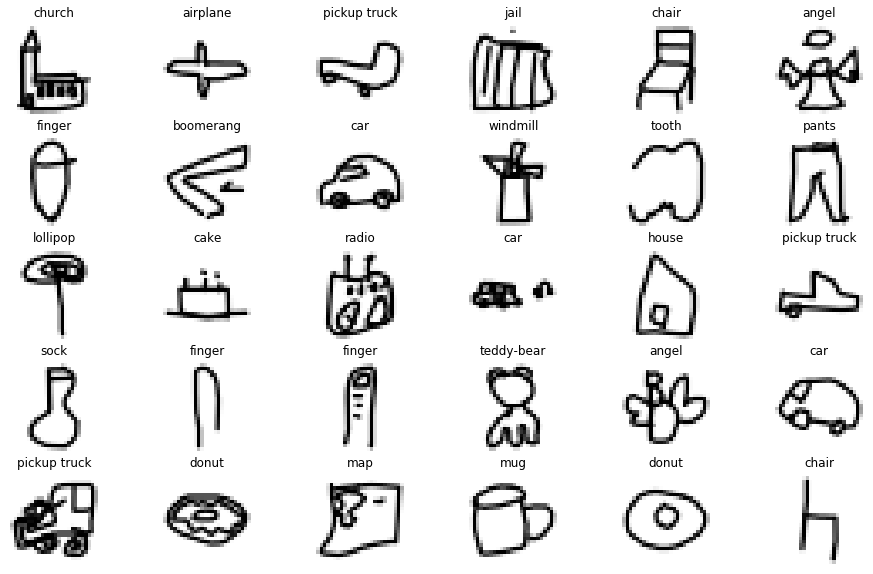

In [6]:
displayRandomImageGrid(loadedData)

## Data Preparation
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas nunc ipsum, condimentum non blandit ac, feugiat at dolor. Sed pulvinar elit ac sagittis faucibus. Curabitur in felis dui. Proin condimentum sagittis enim, et lacinia ante mollis eu. Praesent suscipit tortor non augue auctor egestas. Sed in sapien sed justo ullamcorper ornare sodales ac diam. 

In [7]:
X = []
y = []

# Combine datasets in single array
for key, value in loadedData.items():
    X.append(value)
    y.append(np.full((len(value), 1), key).ravel())

# Cleaning 
del loadedData

# Flatten the arrays
X = np.concatenate(X, axis = 0)
y = np.concatenate(y, axis = 0)

# Size of data
print(f'Size of X list: {len(X)} - Size of y list: {len(y)}.')

Size of X list: 2250000 - Size of y list: 2250000.


In [8]:
# Zip the data then shuffle it
zippedData = list(zip(X, y))
random.shuffle(zippedData)
X, y = zip(*zippedData)

# Cleaning
del zippedData

In [9]:
y = pd.get_dummies(y)
dataDictionary = {index: name for index, name in enumerate(y.columns)}
y = y.values

In [10]:
def createDataLoaders(X, y, train = 0.7, val = 0.15, test = 0.15):
    indxTrain = int(len(X) * train)
    indxTest = int(len(X) * (train + val))
    # Split - Train
    X_train = X[:indxTrain]
    y_train = y[:indxTrain]
    
    # Split - Validation
    X_val = X[indxTrain: indxTest]
    y_val = y[indxTrain: indxTest]
    
    # Split - Testing
    X_test = X[indxTest:]
    y_test = y[indxTest:]
    

    # Training Loader 
    X_tensor_train = torch.from_numpy(np.array(X_train)).type(torch.FloatTensor)
    y_tensor_train = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor)
    trainDataset = torch.utils.data.TensorDataset(X_tensor_train, y_tensor_train)
    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=100)
    
    # Validation Loader 
    X_tensor_val = torch.from_numpy(np.array(X_val)).type(torch.FloatTensor)
    y_tensor_val = torch.from_numpy(np.array(y_val)).type(torch.FloatTensor)
    validationDataset = torch.utils.data.TensorDataset(X_tensor_val, y_tensor_val)
    validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size=50)
    
    # Testing Loader
    X_tensor_test = torch.from_numpy(np.array(X_test)).type(torch.FloatTensor)
    y_tensor_test = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor)
    testDataset = torch.utils.data.TensorDataset(X_tensor_test, y_tensor_test)
    testLoader = torch.utils.data.DataLoader(testDataset, batch_size=50)
    
    return {'train': trainLoader, 'val': validationLoader, 'test': testLoader}

In [11]:
# dataLoaders = createDataLoaders(X, y)

## Upload data to S3

In [12]:
def getS3Datasets(X, y, train = .7, val = .3):
    splitIndex = int(len(X) * train)
    train_X = np.array(X[:splitIndex])
    train_y = np.array(y[:splitIndex])
    val_X = np.array(X[splitIndex:])
    val_y = np.array(y[splitIndex:])
    return [train_y, train_X], [val_y, val_X]

In [13]:
trainData, valData = getS3Datasets(X, y)

In [14]:
with open(transformedFolder + "/train.txt", "wb") as f:
    pickle.dump(trainData, f)

In [15]:
with open(transformedFolder + "/val.txt", "wb") as f:
    pickle.dump(valData, f)

In [16]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'pictionary'
role = sagemaker.get_execution_role()
trainingDataS3 = sagemaker_session.upload_data(path=transformedFolder + '/train.txt', bucket=bucket, key_prefix=prefix)
validationDataS3 = sagemaker_session.upload_data(path=transformedFolder +'/val.txt', bucket=bucket, key_prefix=prefix)

## Memory Cleaning

In [17]:
del X
del y

## Model Training

In [18]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize, dropout = 0.0):
        super(NeuralNetClassifier, self).__init__()    
            
        self.classifier = nn.Sequential(OrderedDict([
            
                      ('linear1', nn.Linear(inputSize, hiddenSize)),
                      ('relu1', nn.ReLU()),

                      ('linear2', nn.Linear(hiddenSize, hiddenSize)),
                      ('batchnorm1', nn.BatchNorm1d(num_features=hiddenSize)),
                      ('relu2', nn.ReLU()),

                      ('dropout1', nn.Dropout(dropout)),
                      
                      ('linear3', nn.Linear(hiddenSize, hiddenSize)),
                      ('relu3', nn.ReLU()),

                      ('linear4', nn.Linear(hiddenSize, hiddenSize)),
                      ('batchnorm2', nn.BatchNorm1d(num_features=hiddenSize)),
                      ('relu4', nn.ReLU()),

                      ('linear5', nn.Linear(hiddenSize, outputSize))
                      
        ])
                          )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [19]:
def Evaluate(Model, DataLoader, Criterion, device):
    Model.eval()
    Model.to(device)
    EvaluationLoss = 0
    EvaluationAccuracy = 0
    for images, labels in DataLoader:
        images, labels = images.to(device), labels.to(device)
        
        Predictions = Model.forward(images)
        EvaluationLoss += Criterion(Predictions, labels).item()

        ExpPreds = torch.exp(Predictions)
        predictedClasses = ExpPreds.max(dim=1).indices.numpy()
        
        CheckPreds = (np.argmax(labels.data, axis = 1).numpy() == predictedClasses)
        EvaluationAccuracy += CheckPreds.mean()
        
    return EvaluationLoss, EvaluationAccuracy

In [20]:
def train(Model, DataLoaders, Optimizer, Criterion,  epochs = 2, gpu = True, Verbose = True):
    # Checking device
    device = torch.device("cuda" if torch.cuda.is_available() and gpu else "cpu")
    print(f"Training on {device}.")
    
    print("Initating Model Training.")
    
    # Setting the model to the device used.
    Model.to(device)
    # Training
    for epoch in range(epochs):
        # Setting the model to training mode.
        Model.train()
        running_loss = 0
        for inputs, labels in DataLoaders['train']:
            
            # Changing the  inputs to the device used.
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Setting gradients to 0
            Optimizer.zero_grad()

            # Forward and backward passes
            outputs = Model.forward(inputs)
            loss = Criterion(outputs, labels)
            loss.backward()
            Optimizer.step()
            
            # Computing Loss
            running_loss += loss.item()
            
        # Verbose
        if Verbose:
            with torch.no_grad():
                ValLoss, ValAcc = Evaluate(Model, DataLoaders['val'], Criterion, device)
            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(DataLoaders['train'])),
                  "Validation Loss: {:.3f}.. ".format(ValLoss/len(DataLoaders['val'])),
                  "Validation Accuracy: {:.3f}".format(ValAcc/len(DataLoaders['val'])))

    print("Model Trained.")
    return Model

In [ ]:
# Parameters
inputSize = 784
hiddenSize = 1000
lossFunction = nn.BCEWithLogitsLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model
neuralNetModel = NeuralNetClassifier(inputSize, hiddenSize, len(dataset), dropout = 0.1).to(device)

# Optimiser
optimiser = optim.Adam(neuralNetModel.parameters(), lr= 0.0001)

# Traing
model = train(neuralNetModel, dataLoaders, optimiser, lossFunction, epochs = 10)

## Model Evaluation
This part is used to evaluate the model created in the notebook. If the performance is satisfactory, then we can move to creating an AWS training job.

In [ ]:
with torch.no_grad():
    valLoss, valAcc = Evaluate(model, dataLoaders['val'], lossFunction, device)
    trainLoss, trainAcc = Evaluate(model, dataLoaders['train'], lossFunction, device)
    
print(f"Training Loss: {round(trainLoss/len(dataLoaders['train']),2)} - \
      Training Accuracy: {round(trainAcc/len(dataLoaders['train']),2)}.")
      
print(f"Validation Loss: {round(valLoss/len(dataLoaders['val']),2)} - \
      Validation Accuracy: {round(valAcc/len(dataLoaders['val']),2)}.")

## Create AWS Training Job

In [21]:
estimator = PyTorch(entry_point="train.py",
                    role=role,
                    framework_version='0.4.0',
                    py_version = 'py3',
                    instance_count=1,
                    instance_type='ml.m4.xlarge',
                    source_dir='train',
                    hyperparameters={
                        'epoch': 10,
                        'hidden_size': 1000,
                        'input_size': 784,
                        'dropout': 0.1,
                        'output_size': len(dataset)
                    })

In [22]:
estimator.fit({'training': trainingDataS3})

2021-02-21 13:11:01 Starting - Starting the training job...
2021-02-21 13:11:24 Starting - Launching requested ML instancesProfilerReport-1613913060: InProgress
......
2021-02-21 13:12:25 Starting - Preparing the instances for training......
2021-02-21 13:13:25 Downloading - Downloading input data...
2021-02-21 13:14:00 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-02-21 13:14:01,398 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-02-21 13:14:01,401 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-02-21 13:14:01,420 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-02-21 13:14:04,450 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-02-21 13:14:04,771 sagemaker-containers INFO     Module train does no

## Deploying Real-Time Predictor

In [24]:
estimator.model_data

's3://sagemaker-eu-west-1-766105661738/sagemaker-pytorch-2021-02-21-13-11-00-721/output/model.tar.gz'

In [27]:
class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

In [28]:
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     py_version = 'py3',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
# ---------------!

---------------!

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [67]:
predictor.endpoint_name

'sagemaker-pytorch-2021-02-21-14-53-45-477'

## Final Model Evaluation

In [62]:
labels = valData[0][:10000]
data = valData[1][:10000]

In [63]:
# valData
fullLabels = []
fullPredictions = []
for i in range(len(labels)):
    if i % 1000 == 0:
        print(i)
    fullLabels.append(np.argmax(labels[i]))
    dataPred = ','.join(data[i].astype(int).astype(str))
    fullPredictions.append(int(predictor.predict(dataPred)))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [64]:
print(f"The model's accuracy is: {round(accuracy_score(fullPredictions, fullLabels),2)}.")

The model's accuracy is: 0.94.


## Model Information & Deletion

In [65]:
estimator.model_data

's3://sagemaker-eu-west-1-766105661738/sagemaker-pytorch-2021-02-21-13-11-00-721/output/model.tar.gz'

In [66]:
dataDictionary

{0: 'The Mona Lisa',
 1: 'airplane',
 2: 'angel',
 3: 'bicycle',
 4: 'bird',
 5: 'boomerang',
 6: 'cake',
 7: 'car',
 8: 'castle',
 9: 'cell phone',
 10: 'chair',
 11: 'church',
 12: 'cookie',
 13: 'cruise ship',
 14: 'donut',
 15: 'finger',
 16: 'hat',
 17: 'house',
 18: 'jail',
 19: 'lollipop',
 20: 'map',
 21: 'mug',
 22: 'pants',
 23: 'pickup truck',
 24: 'rabbit',
 25: 'radio',
 26: 'sock',
 27: 'teddy-bear',
 28: 'tooth',
 29: 'windmill'}

In [68]:
predictor.delete_endpoint()

In [ ]:
class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')
        
model = PyTorchModel(model_data='s3://sagemaker-eu-west-1-766105661738/sagemaker-pytorch-2021-02-20-11-07-08-943/output/model.tar.gz',
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     py_version = 'py3',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
# -------------!